In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools

In [17]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

258.9605074819228

In [18]:
# Define unknown constants
g_agg = 1e-10 #g_agg (axion-photon-photon) coupling constant; in GeV^(-1) (for photon coalescence)
g_ag = 1e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
lmda = (g_agg/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3

vol_cell = 67.71 #In AA^3, from Dent paper

In [19]:
vol

2.3758294442772804e+27

In [53]:
#Define useful functions
def make_hkl(max_h=5,max_k=5,max_l=5, s=False):
    '''This might need to be remade based on what the "primitives" are. Condition is h,k,l must be even.
    F mandates h,k,l share a parity, and S mandates h+k+l is even'''
    full_arr = list(itertools.product(range(max_h), range(max_k), range(max_l)))
    if s:
        filter_func = lambda triple: (triple[0]%2 == triple[1]%2) & (triple[0]%2 == triple[2]%2) & (triple[0]%2 == 0)
        return np.array(list(filter(filter_func, full_arr)))[1:]
    else:
        filter_func = lambda triple: (triple[0]%2 == triple[1]%2) & (triple[0]%2 == triple[2]%2)
        return np.array(list(filter(filter_func, full_arr)))[1:]


def make_hkl_s(max_h=5,max_k=5,max_l=5):
    '''hkl array, where the only condition is h+k+l must be even'''
    full_list = list(itertools.product(range(max_h),range(max_k),range(max_l)))
    filter_func = lambda triple: sum(triple)%2 == 0
    return np.array(list(filter(filter_func, full_list)))[1:] #remove (0,0,0)
    

def mod2(vec3):
    '''Returns the dimensionless magnitude of an array of vectors in the (h,k,l) basis. Factor of 2pi/a has to be multiplied manually'''
    return 3*(vec3[:,0]**2 + vec3[:,1]**2 + vec3[:,2]**2) - 2*(vec3[:,0]*vec3[:,1] + vec3[:,1]*vec3[:,2] + vec3[:,2]*vec3[:,0])

def gdotk(hkl_arr):
    '''Returns gHAT dot kHAT, assuming kHat is in the cartesian x direction'''
    return (-hkl_arr[:,0]+hkl_arr[:,1]+hkl_arr[:,2])/np.sqrt(mod2(hkl_arr))

def w_func(Ea, dVector = False, Delta=1.5, E1=1, E2=6):
    '''Returns array of W(Ea, Delta, E1, E2) where everything is in keV. Infinite Ea is dealt with'''
    w_list = []
    if dVector:
        entangle = np.dstack((Ea, Delta))
        for index in range(entangle.shape[1]):
            E = entangle[0,index,0]
            D = entangle[0,index,1]
            if np.isinf(E) or E<0:
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*D)) - erf((E-E2)/(np.sqrt(2)*D)))
                w_list.append(w)
    else:
        for E in Ea:
            if np.isinf(E) or E<0:
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*Delta)) - erf((E-E2)/(np.sqrt(2)*Delta)))
                w_list.append(w)
    return np.array(w_list)

def make_dpde(Energy_array):
    '''Creates dPhi/dE for the parametrised blackbody-like form appearing in older papers. Assumes no axion mass.
    Units of cm^(-2) s^(-1) keV^(-1)'''
    dpdt_list = []
    for E in Energy_array:
        if np.isinf(E):
            dpdt_list.append(0)
        else:
            dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))
    return np.array(dpdt_list)

def FA_q(q2, Z=51):
    '''Returns form factor given an input in AA^(-2)'''
    qme = q2/0.1308
    A = 184.15*np.exp(-1/2)*Z**(-1/3)
    return Z*A**2*qme/(1+A**2*qme)

def make_delta(energy):
    '''Returns Delta (approx 15%*sqrt(E)*E) for an energy array, setting infinities and negatives to zero'''
    output = []
    for E in energy:
        if E<0 or np.isinf(E):
            output.append(0)
        else:
            output.append(0.15463505424062166*np.sqrt(E/1000)*E)
    return np.array(output)


Define the possible values of $(h,k,l)$ and therefore $\vec{G} = \frac{2\pi}{a}(h,k,l)$. Define also $|\vec{G}|^2$ and therefore $F_A(q)$ and $\hat{G}$

In [54]:
hkl = np.array(make_hkl(max_h = 5, 
                        max_k = 5,
                        max_l = 5,
                        s=True)) #Indexed to [25,2], removing trivial case

g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
FAq = FA_q(mod2_g)

ginv_array = 1/mod2_g

ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

ghat = g_arr*np.sqrt(ginv_replicant)

Define $\sin^2(2\theta)$ with:
$$\sin^2(2\theta) = 4(\hat{G} \cdot \hat{k})^2 (1-(\hat{G} \cdot \hat{k})^2)$$

Creating the sum
$$\sum_{\vec{G}} \frac{|F(\vec{G}) S(\vec{G})|^2}{|\vec{G}|^2} \sin^2(\theta)$$
The next step is implementing $\frac{d\phi}{dE}$ and $\mathcal{W}$.


In [41]:
gk = gdotk(g_arr)

sin2 = 4*gk**2*(1-gk**2)

summand = FAq*ginv_array*sin2*4 #Use *4 if implementing s

np.sum(summand)

118.20336348668243

Under the Bragg condition,
$$E_a = \frac{\hbar c |\vec{G}|^2}{2\hat{k}\cdot \vec{G}}$$
Note that $E_a$ diverges when $\hat{k}$ is perpendicular to $\vec{G}$. These infinities are dealt with later by asserting that they aren't detected, via the $\mathcal{W}$ function:
$$\mathcal{W}(E_1,E_2,E_A,\Delta) = \frac{1}{\sqrt{2\pi} \Delta} \int_{E_1}^{E_2} e^{-\frac{1}{2} \left(\frac{u-E_a}{\Delta} \right)^2}du = \frac{1}{2} \left[ erf\left(\frac{E_a-E_1}{\sqrt{2}\Delta}\right) - erf\left(\frac{E_a-E_2}{\sqrt{2}\Delta}\right) \right]$$

This limits to a unit box between $E_1$ and $E_2$ for small detector resolution $\Delta$

In [50]:
E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
#The infinities here are fine; they go to zero in the W function


W = w_func(E_arr, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report

new_summand = W*summand
np.sum(new_summand)

C:\Users\taase\AppData\Local\Temp\ipykernel_16200\3318436611.py:1: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


50.65820858381326

Use blackbody-like parametrisation of solar axion flux:
$$\frac{d\Phi}{dE} = \sqrt{\lambda} \frac{\Phi_0}{E_0} \frac{(E/E_0)^3}{e^{E/E_0} - 1}$$
From Cebrian et.al 1999, constants are defined in the earlier section

In [24]:
dphi_de = make_dpde(E_arr)
final_summand = dphi_de*new_summand
np.sum(final_summand)

2244940375172.0425

In [25]:
(unit.AA/unit.cm).si

Unit(dimensionless with a scale of 1.0000000000000002e-08)

In [33]:
nt_constant = np.pi*(g_ag*1000)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
#Conversion factor of angstroms to cm missing somewhere
#Absorption also looks like it's a huge deal (order -9 or so)
final_dndt = nt_constant*np.sum(1e-16*final_summand) #in s^(-1), 1e-16 converts angstroms and cm
print("dN/dt = {:.3e} s^(-1)".format(final_dndt))

dN/dt = 2.808e+07 s^(-1)


The final value is:
$$\frac{dN}{dt} = \pi g_{a\gamma}^2 (\hbar c)^3 \frac{V}{V_{cell}^2}\sum_{\vec{G}} \frac{d\Phi_a}{dE_a} \frac{|F(\vec{G}) S(\vec{G})|^2}{|\vec{G}|^2} \sin^2\left[2\theta(\vec{k},\vec{G})\right] \mathcal{W}\left(E_a(\vec{G}),\Delta \right)$$
Current issues:
- ~~My value for $F(\vec{G})$ does not have an atomic scattering factor~~
    - ~~This is doable depending on the linearity of f with compounds instead of atoms~~ Ignore the Gaussian/FT definition, use their parametrisation
    - Note: their parametrisation appears to have the wrong limit: they claim $F(0)=Z$, but actually $F(0)=0$ and $F(\infty)=Z$
- ~~$\Delta$ is following what Dent et.al said, not accurate to SABRE~~
- I have no absorption $I(\vec{k}, \vec{G})$
    - This _might_ be doable if I copy the $\lambda$ values from the table. Summation over N atoms will be hard -- working on it
- ~~My Axion flux is a simple blackbody-like parametrisation without considering Axion mass or separating processes~~
    - ~~Moreover I only have photon coupling, no electron coupling when Redondo argues that a-e is much greater than Primakoff~~
    - ~~However, Dent only looks at Primakoff when this was already known; is ae coupling not detectable by crystals?~~
    - Only consider photons, since the detection efficiency of axion-electron coupling is not competitive for SABRE
- **$\vec{k}$ was arbitrarily chosen to be convenient: I need to implement the real solar position**
    - The algorithm Dent uses has a C file that does it all I think

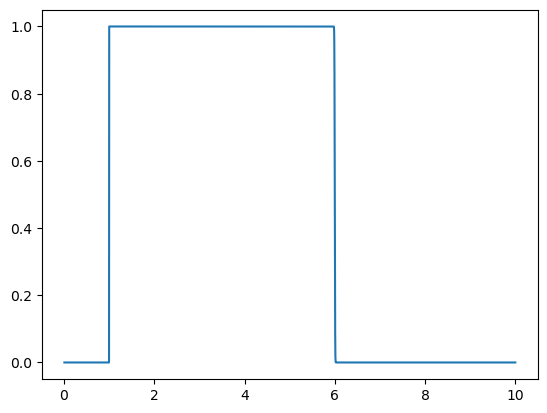

In [52]:
x_axis = np.arange(0.01,10,0.001)
y_axis = w_func(x_axis, dVector=True, Delta = 0.014*np.sqrt(x_axis/1000)*x_axis)

plt.plot(x_axis, y_axis)
plt.show()

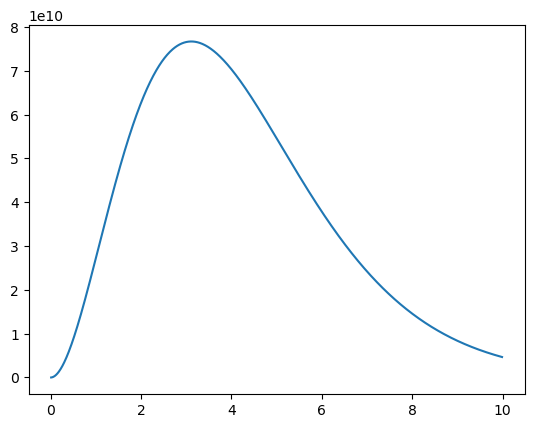

In [28]:
plt.plot(x_axis, make_dpde(x_axis))

(array([7., 9., 3., 0., 0., 0., 3., 0., 0., 4.]),
 array([0.01746055, 0.02502679, 0.03259304, 0.04015928, 0.04772552,
        0.05529176, 0.062858  , 0.07042424, 0.07799048, 0.08555672,
        0.09312296]),
 <BarContainer object of 10 artists>)

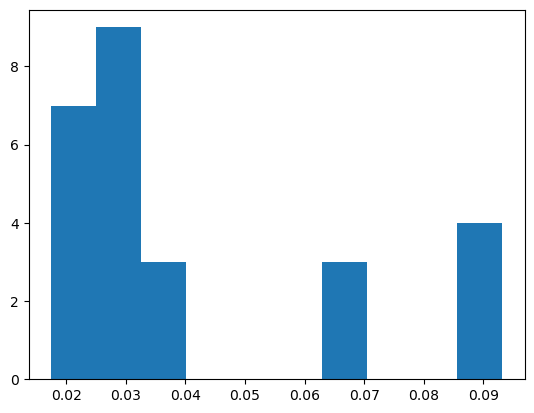

In [29]:
plt.hist(ginv_array)